# Topic Classification Using Unsupervised and Supervised Approaches Part 2
This assignment compares how well unsupervised matrix factorisation and two supervised learning models classify [BBC News data](https://www.kaggle.com/competitions/learn-ai-bbc/data). This is the second notebook and focuses on the supervised learning models.

In [1]:
# general libraries
import configparser
import numpy as np
import pandas as pd

# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# modelling libraries
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import spacy
from spacy.tokens import DocBin

# get rid of the seaborn FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# load the data
train = pd.read_csv('./data/learn-ai-bbc/BBC News Train.csv')
test = pd.read_csv('./data/learn-ai-bbc/BBC News Test.csv')

# load the english spacy model
nlp = spacy.load("en_core_web_lg")

# check out the number of tokens in the articles
train['NumChars'] = train.Text.apply(lambda x: len(x))
train['NumWords'] = train.Text.apply(lambda x: len(x.split()))

# remove articles in the top 1%
top = np.quantile(train.NumWords, q=0.99)
train_sub = train.loc[train.NumWords < top]

## Task 6: Supervised Learning - Spacy
Spacy has an inbuilt text categoriser ('textcat') that can be added as a component to its NLP pipeline.

There are 3 CPU architectures available:
- Stacked ensemble of a linear BoW and neural network model. The neural network is built on top of a Tok2Vec (token to vector) layer and uses attention. This is the default architecture.
- Neural network model where token vectors are calculated using a CNN. According to the documentation, it's typically less accurate than the default but faster.
- n-gram BoW model. Runs the fastest, but has particular trouble with short texts (Not too much of an issue in this case, but could be if analysing customer feedback for example).

If a GPU is available, then a transformer model from the HuggingFace transformers library with pre-trained weights and a PyTorch implementation can be added.

**The first model to be trained and evaluated will be a BoW model without a GPU.**

In [4]:
# check if textcat is part of the pipeline
if nlp.has_pipe("textcat"):
    pass
else:
    textcat = nlp.add_pipe("textcat", last=True)
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'textcat']


In [7]:
# add the labels (categories) to the pipeline component
textcat.add_label("business")
textcat.add_label("entertainment")
textcat.add_label("politics")
textcat.add_label("sport")
textcat.add_label("tech")

# double-check they've been added
textcat.labels

('business', 'entertainment', 'politics', 'sport', 'tech')

In [6]:
default_config = nlp.get_pipe_meta("textcat").default_config
default_config

{'threshold': 0.0,
 'model': {'@architectures': 'spacy.TextCatEnsemble.v2',
  'linear_model': {'@architectures': 'spacy.TextCatBOW.v2',
   'exclusive_classes': True,
   'ngram_size': 1,
   'no_output_layer': False},
  'tok2vec': {'@architectures': 'spacy.Tok2Vec.v2',
   'embed': {'@architectures': 'spacy.MultiHashEmbed.v2',
    'width': 64,
    'rows': [2000, 2000, 500, 1000, 500],
    'attrs': ['NORM', 'LOWER', 'PREFIX', 'SUFFIX', 'SHAPE'],
    'include_static_vectors': False},
   'encode': {'@architectures': 'spacy.MaxoutWindowEncoder.v2',
    'width': 64,
    'window_size': 1,
    'maxout_pieces': 3,
    'depth': 2}}},
 'scorer': {'@scorers': 'spacy.textcat_scorer.v2'}}

First rejig the config file for **efficiency**, noting it changes the default model architecture from an ensemble to a BoW.
- Step 1: generate a base config file using https://spacy.io/usage/training#quickstart:
    - Components: textcat
    - Text classification: Exclusive categories
    - Hardware: CPU
    - Optimise for: efficiency
- Step 2: Create a complete config file with all the other components auto-filled to their defaults

In [9]:
# CLI command
!python -m spacy init fill-config ./configs/base_efficiency_cpu_config.cfg ./configs/efficiency_cpu_config.cfg --diff
# --diff produces a helpful comparison to the base config file (i.e. what's been added/removed)

[+] Auto-filled config with all values

============================= START CONFIG DIFF =============================

[paths]
train = null
dev = null
vectors = null
init_tok2vec = null

[system]
gpu_allocator = null
seed = 0

[nlp]
lang = "en"
pipeline = ["textcat"]
batch_size = 1000
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}
vectors = {"@vectors":"spacy.Vectors.v1"}

[components]

[components.textcat]
factory = "textcat"
scorer = {"@scorers":"spacy.textcat_scorer.v2"}
threshold = 0.0

[components.textcat.model]
@architectures = "spacy.TextCatBOW.v2"
exclusive_classes = true
ngram_size = 1
no_output_layer = false
nO = null

[corpora]

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0
gold_preproc = false
limit = 0
augmenter = null

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0
gold_preproc = false
limit = 0
augmenter = null

[t

In [10]:
# view the configuration file
def read_spacy_config(file_path):
    config = configparser.ConfigParser()
    config.read(file_path)

    config_dict = {}
    for section in config.sections():
        config_dict[section] = {}
        for option in config.options(section):
            config_dict[section][option] = config.get(section, option)

    return config_dict


file_path = './configs/efficiency_cpu_config.cfg'
textcat_config = read_spacy_config(file_path)
textcat_config

{'paths': {'train': 'null',
  'dev': 'null',
  'vectors': 'null',
  'init_tok2vec': 'null'},
 'system': {'gpu_allocator': 'null', 'seed': '0'},
 'nlp': {'lang': '"en"',
  'pipeline': '["textcat"]',
  'batch_size': '1000',
  'disabled': '[]',
  'before_creation': 'null',
  'after_creation': 'null',
  'after_pipeline_creation': 'null',
  'tokenizer': '{"@tokenizers":"spacy.Tokenizer.v1"}',
  'vectors': '{"@vectors":"spacy.Vectors.v1"}'},
 'components': {},
 'components.textcat': {'factory': '"textcat"',
  'scorer': '{"@scorers":"spacy.textcat_scorer.v2"}',
  'threshold': '0.0'},
 'components.textcat.model': {'@architectures': '"spacy.TextCatBOW.v2"',
  'exclusive_classes': 'true',
  'ngram_size': '1',
  'no_output_layer': 'false',
  'no': 'null'},
 'corpora': {},
 'corpora.dev': {'@readers': '"spacy.Corpus.v1"',
  'path': '${paths.dev}',
  'max_length': '0',
  'gold_preproc': 'false',
  'limit': '0',
  'augmenter': 'null'},
 'corpora.train': {'@readers': '"spacy.Corpus.v1"',
  'path': '$

In [11]:
# split the data into a training and dev set (80/20 split)
# ensure that the category splits are roughly even
train_data, dev_data = train_test_split(train_sub, stratify=train_sub.Category, test_size=0.2,
                                        random_state=42)
train_data.reset_index(inplace=True, drop=True)
dev_data.reset_index(inplace=True, drop=True)


# convert the data to spacy's required training format: https://spacy.io/api/data-formats#binary-training
def convert_data(output_path, df, label='Category'):
    # extract all the unique categories
    cats = set(df[label])

    # create a one-hot-dictionary for each unique category
    one_hot_dicts = {}
    for c1 in cats:
        one_hot_dict = {c2: (1 if c2 == c1 else 0) for c2 in cats}
        one_hot_dicts[c1] = one_hot_dict
    print(one_hot_dicts)

    # create spacy and DocBin objects
    nlp = spacy.blank('en')
    db = DocBin()

    # for each row in the dataframe...
    for idx, row in df.iterrows():
        # locate just the text and label information
        text = row['Text']
        cat = row['Category']

        # make a doc from the text
        doc = nlp.make_doc(text)
        # add the relevant one-hot-dictionary
        doc.cats = one_hot_dicts[cat]
        # print(one_hot_dicts[cat])
        # add it to the DocBin object
        db.add(doc)

    # write the DocBin object to disk
    db.to_disk(output_path)


convert_data("./corpora/train.spacy", df=train_data)
convert_data("./corpora/dev.spacy", df=dev_data)

In [19]:
# train the model: https://spacy.io/usage/training#quickstart
# override various sections using the syntax: --section.option
!python -m spacy train ./configs/efficiency_cpu_config.cfg --output ./outputs2 --paths.train ./corpora/train.spacy --paths.dev ./corpora/dev.spacy --verbose

[i] Saving to output directory: outputs2
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['textcat']
[i] Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.16        5.90    0.06
  0     200         15.19       90.06    0.90
  0     400          4.26       91.09    0.91
  0     600          2.46       95.02    0.95
  0     800          2.45       92.84    0.93
  0    1000          2.98       95.78    0.96
  1    1200          1.62       96.89    0.97
  1    1400          0.39       95.66    0.96
  1    1600          0.45       96.18    0.96
  1    1800          0.00       96.83    0.97
  1    2000          1.15       95.25    0.95
  1    2200          0.22       96.91    0.97
  2    2400          0.00       97.64    0.98
  2    2600     

[2023-12-18 15:51:32,922] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
[2023-12-18 15:51:33,247] [INFO] Set up nlp object from config
[2023-12-18 15:51:33,260] [DEBUG] Loading corpus from path: corpora\dev.spacy
[2023-12-18 15:51:33,268] [DEBUG] Loading corpus from path: corpora\train.spacy
[2023-12-18 15:51:33,268] [INFO] Pipeline: ['textcat']
[2023-12-18 15:51:33,270] [INFO] Created vocabulary
[2023-12-18 15:51:33,270] [INFO] Finished initializing nlp object
[2023-12-18 15:51:45,808] [INFO] Initialized pipeline components: ['textcat']
[2023-12-18 15:51:45,829] [DEBUG] Loading corpus from path: corpora\dev.spacy
[2023-12-18 15:51:45,834] [DEBUG] Loading corpus from path: corpora\train.spacy
[2023-12-18 15:51:45,839] [DEBUG] Removed existing output directory: outputs2\model-best
[2023-12-18 15:51:45,839] [DEBUG] Removed existing output directory: outputs2\model-last


In [20]:
# evaluate model performance
!python -m spacy evaluate ./outputs/efficiency-cpu-model-best/ ./corpora/train.spacy

[i] Using CPU

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   99.92 
SPEED               161357


=========================== Textcat F (per label) ===========================

                     P        R        F
sport           100.00   100.00   100.00
tech            100.00   100.00   100.00
entertainment   100.00   100.00   100.00
business        100.00    99.63    99.81
politics         99.54   100.00    99.77


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
tech               1.00
entertainment      1.00
business           1.00
politics           1.00



In [21]:
!python -m spacy evaluate ./outputs/efficiency-cpu-model-best/ ./corpora/dev.spacy

[i] Using CPU

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   97.99 
SPEED               130172


=========================== Textcat F (per label) ===========================

                     P        R       F
sport            97.18   100.00   98.57
tech            100.00    98.04   99.01
entertainment   100.00    98.15   99.07
business         95.65    98.51   97.06
politics         98.08    94.44   96.23


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
tech               1.00
entertainment      1.00
business           1.00
politics           1.00



We can see therefore that the scoring during model training is for the dev set (as it should be). Also, the F-score on the dev set is only slightly lower than the training set, indicating that it's not overfitting.

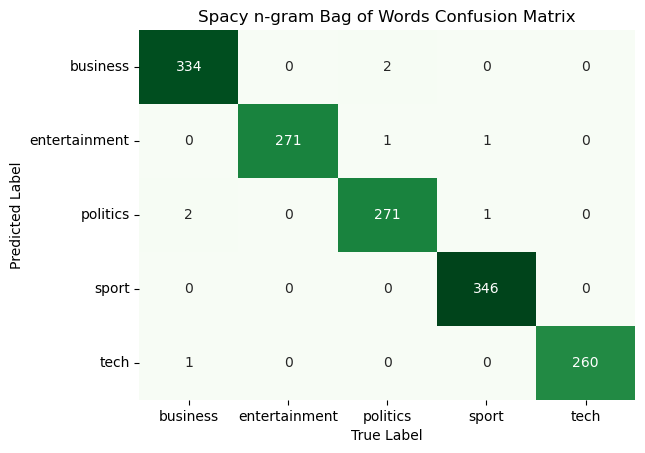

In [22]:
# load the model
nlp_efficiency = spacy.load("./outputs/efficiency-cpu-model-best")

def generate_predictions(df, text_col='Text', label_col='Category', textcat_model=nlp_efficiency):
    data = df[text_col].to_list()

    pred_cats = []
    for article in data:
        doc = textcat_model(article)
        scores_dict = doc.cats
        pred_cat = max(scores_dict, key=lambda k: scores_dict[k])
        pred_cats.append(pred_cat)
    if label_col is None:
        pred_df = pd.DataFrame(data = {'ArticleId': df['ArticleId'], 'PredictedLabel': pred_cats, 'Text': df[text_col]})
    else:
        pred_df = pd.DataFrame(data = {'ArticleId': df['ArticleId'], 'Actual': df[label_col],
                                       'Predicted': pred_cats, 'Text': df[text_col]})

    return pred_df


train_preds = generate_predictions(train)


def plot_confusion_matrix(true_labels, predicted_labels, title,
                          cats=['business', 'entertainment', 'politics', 'sport', 'tech']):
    cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    cm_df = pd.DataFrame(cm, columns=cats, index=cats)
    ax = sns.heatmap(cm_df, annot=True, fmt=".0f", cbar=False, cmap="Greens")
    ax.set(xlabel="True Label", ylabel="Predicted Label", title=title)

plot_confusion_matrix(train_preds.Actual, train_preds.Predicted, title='Spacy n-gram Bag of Words Confusion Matrix')

In [27]:
accuracy = accuracy_score(train_preds.Actual, train_preds.Predicted)
print("Training accuracy:", accuracy)

f1 = f1_score(train_preds.Actual, train_preds.Predicted, average='weighted')
print("Training F1 score:", f1)

# make predictions
test_preds = generate_predictions(test, label_col=None)

kaggle_submission = test_preds.loc[:, ['ArticleId', 'PredictedLabel']]
kaggle_submission.columns=['ArticleId', 'Category']
kaggle_submission.to_csv('./outputs/kaggle submission efficient textcat.csv', index=False)

Training accuracy: 0.9946308724832215
Training F1 score: 0.9946321881819775


The model performed well on both the training and test sets, achieving a near 100% accuracy on the full training data and around 97% on the test data.

**The second model to be trained and evaluated will be a stacked ensemble model without a GPU.**

Now rejig the config file for **accuracy**. This keeps the default model architecture.
- Step 1: generate a base config file using https://spacy.io/usage/training#quickstart:
    - Components: textcat
    - Text classification: Exclusive categories
    - Hardware: CPU
    - Optimise for: accuracy
- Step 2: Create a complete config file with all the other components auto-filled to their defaults

In [29]:
# CLI command
!python -m spacy init fill-config ./configs/base_accuracy_cpu_config.cfg ./configs/accuracy_cpu_config.cfg --diff

[+] Auto-filled config with all values

============================= START CONFIG DIFF =============================

[paths]
train = null
dev = null
vectors = "en_core_web_lg"
init_tok2vec = null

[system]
gpu_allocator = null
seed = 0

[nlp]
lang = "en"
pipeline = ["tok2vec","textcat"]
batch_size = 1000
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}
vectors = {"@vectors":"spacy.Vectors.v1"}

[components]

[components.textcat]
factory = "textcat"
scorer = {"@scorers":"spacy.textcat_scorer.v2"}
threshold = 0.0

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"
nO = null

[components.textcat.model.linear_model]
@architectures = "spacy.TextCatBOW.v2"
exclusive_classes = true
ngram_size = 1
no_output_layer = false
nO = null

[components.textcat.model.tok2vec]
@architectures = "spacy.Tok2VecListener.v1"
width = ${components.tok2vec.model.encode.width}
upstream = "*"

[component

In [30]:
# view the configuration file
file_path = './configs/accuracy_cpu_config.cfg'
textcat_config = read_spacy_config(file_path)
textcat_config

{'paths': {'train': 'null',
  'dev': 'null',
  'vectors': '"en_core_web_lg"',
  'init_tok2vec': 'null'},
 'system': {'gpu_allocator': 'null', 'seed': '0'},
 'nlp': {'lang': '"en"',
  'pipeline': '["tok2vec","textcat"]',
  'batch_size': '1000',
  'disabled': '[]',
  'before_creation': 'null',
  'after_creation': 'null',
  'after_pipeline_creation': 'null',
  'tokenizer': '{"@tokenizers":"spacy.Tokenizer.v1"}',
  'vectors': '{"@vectors":"spacy.Vectors.v1"}'},
 'components': {},
 'components.textcat': {'factory': '"textcat"',
  'scorer': '{"@scorers":"spacy.textcat_scorer.v2"}',
  'threshold': '0.0'},
 'components.textcat.model': {'@architectures': '"spacy.TextCatEnsemble.v2"',
  'no': 'null'},
 'components.textcat.model.linear_model': {'@architectures': '"spacy.TextCatBOW.v2"',
  'exclusive_classes': 'true',
  'ngram_size': '1',
  'no_output_layer': 'false',
  'no': 'null'},
 'components.textcat.model.tok2vec': {'@architectures': '"spacy.Tok2VecListener.v1"',
  'width': '${components.tok

In [ ]:
# train the model: https://spacy.io/usage/training#quickstart
# override various sections using the syntax: --section.option
!python -m spacy train ./configs/accuracy_cpu_config.cfg --output ./outputs --paths.train ./corpora/train.spacy --paths.dev ./corpora/dev.spacy --verbose

In [ ]:
# evaluate model performance
!python -m spacy evaluate ./outputs/accuracy-cpu-model-best/ ./corpora/train.spacy

In [ ]:
!python -m spacy evaluate ./outputs/accuracy-cpu-model-best/ ./corpora/dev.spacy

In [ ]:
# load the model
nlp_accuracy = spacy.load("./outputs/accuracy-cpu-model-best")

train_preds = generate_predictions(train)

plot_confusion_matrix(train_preds.Actual, train_preds.Predicted, title='Spacy n-gram Bag of Words Confusion Matrix')